In [3]:
print("Hello World")

Hello World


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import Counter
import plotly.express as px

## Loading Dataset

In [5]:

# Try reading the CSV file with a different encoding
try:
    store = pd.read_csv("Sample-Superstore.csv", encoding='latin-1')
except UnicodeDecodeError:
    print("Error: Unable to read the file with 'latin-1' encoding.")
    try:
        store = pd.read_csv("Sample-Superstore.csv", encoding='utf-16')
    except UnicodeDecodeError:
        print("Error: Unable to read the file with 'utf-16' encoding.")

## Renaming features

In [6]:

## renaming of the columns to get rid of the space in between column names 
store.rename(columns={"Row ID":"RowID","Order ID": "OrderID", "Order Date": "OrderDate", "Ship Date": "ShipDate", "Ship Mode": "ShipMode", "Customer ID": "CustomerID", "Customer Name": "CustomerName", "Postal Code": "PostalCode", "Product ID": "ProductID","Sub-Category":"SubCategory", "Product Name": "ProductName"}, inplace=True)


In [7]:
#We need to fix OrderDate and ship date to be YYYY/MM/DD (can be ordered easily even when seen as a string). 
store[['OrderDate','ShipDate']] = store[['OrderDate','ShipDate']].apply(pd.to_datetime)

## Creation of new Dataframe

In [8]:
"""""
Creating Dataframe for different Parameters.

The paramaters includes:
                        Monetary (amount of money spent)
                        Frequency (how frequently the customer bought something)
                        Recency (how many days has passed from last date to their last purchase)

"""

'""\nCreating Dataframe for different Parameters.\n\nThe paramaters includes:\n                        Monetary (amount of money spent)\n                        Frequency (how frequently the customer bought something)\n                        Recency (how many days has passed from last date to their last purchase)\n\n'

In [8]:

store_monetary = store.groupby('CustomerID', as_index=False)['Sales'].sum()
##renaming sales column to Amount
store_monetary.rename(columns={"Sales":"Amount"},inplace=True)
store_monetary.head()

,CustomerID,Amount
0,AA-10315,5563.560
1,AA-10375,1056.390
2,AA-10480,1790.512
3,AA-10645,5086.935
4,AB-10015,886.156


In [9]:
store_monetary.head()

,CustomerID,Amount
0,AA-10315,5563.560
1,AA-10375,1056.390
2,AA-10480,1790.512
3,AA-10645,5086.935
4,AB-10015,886.156


In [10]:
store_frequency = store.groupby('CustomerID', as_index=False)['OrderID'].count()
store_frequency

,CustomerID,OrderID
0,AA-10315,11
1,AA-10375,15
2,AA-10480,12
3,AA-10645,18
4,AB-10015,6
...,...,...
788,XP-21865,28
789,YC-21895,8
790,YS-21880,12
791,ZC-21910,31


In [11]:
store_recency = store.groupby('CustomerID', as_index=False)['Sales'].sum()
store_recency.head()

,CustomerID,Sales
0,AA-10315,5563.560
1,AA-10375,1056.390
2,AA-10480,1790.512
3,AA-10645,5086.935
4,AB-10015,886.156


In [12]:

# Find the last order date in the dataset
reference_date = store['OrderDate'].max()

# Calculate the Recency for each customer
store_recency = store.groupby('CustomerID')['OrderDate'].max().reset_index()
store_recency['Recency'] = (reference_date - store_recency['OrderDate']).dt.days

# Display the first few rows of the resulting DataFrame

store_recency.head()

,CustomerID,OrderDate,Recency
0,AA-10315,2017-06-29,184
1,AA-10375,2017-12-11,19
2,AA-10480,2017-04-15,259
3,AA-10645,2017-11-05,55
4,AB-10015,2016-11-10,415


In [13]:

# Rename columns in store_frequency to match 'CustomerID' for merging
store_frequency = store.groupby('CustomerID')['OrderID'].count().reset_index(name='Frequency')

# Merge the dataframes
parameters = pd.merge(store_monetary, store_frequency, on='CustomerID')
parameters = pd.merge(parameters, store_recency[['CustomerID', 'Recency']], on='CustomerID')

# Display the first few rows of the resulting DataFrame
parameters.head()

,CustomerID,Amount,Frequency,Recency
0,AA-10315,5563.560,11,184
1,AA-10375,1056.390,15,19
2,AA-10480,1790.512,12,259
3,AA-10645,5086.935,18,55
4,AB-10015,886.156,6,415


In [14]:
parameters.head()

,CustomerID,Amount,Frequency,Recency
0,AA-10315,5563.560,11,184
1,AA-10375,1056.390,15,19
2,AA-10480,1790.512,12,259
3,AA-10645,5086.935,18,55
4,AB-10015,886.156,6,415


## Visualization of Outliers

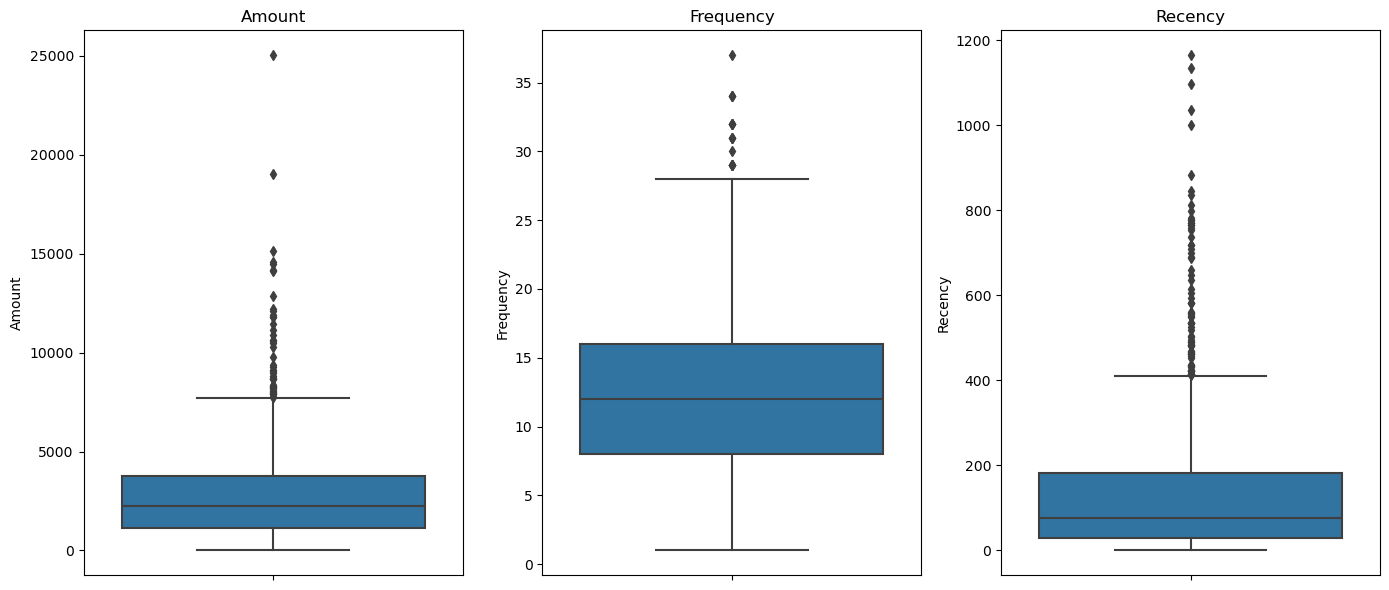

In [15]:


# Create boxplots for Amount, Frequency, and Recency
plt.figure(figsize=(14, 6))

# Amount boxplot
plt.subplot(1, 3, 1)
sns.boxplot(y=parameters['Amount'])
plt.title('Amount')

# Frequency boxplot
plt.subplot(1, 3, 2)
sns.boxplot(y=parameters['Frequency'])
plt.title('Frequency')

# Recency boxplot
plt.subplot(1, 3, 3)
sns.boxplot(y=parameters['Recency'])
plt.title('Recency')

plt.tight_layout()
plt.show()


## Outliers Identification and Removal 

In [17]:
# Function to calculate IQR and filter out outliers
#def remove_outliers_iqr(df, column):
    #Q1 = df[column].quantile(0.25)
    #Q3 = df[column].quantile(0.75)
    #IQR = Q3 - Q1
    #lower_bound = Q1 - 1.5 * IQR
    #upper_bound = Q3 + 1.5 * IQR
    #return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply the function to each column
#parameters_cleaned = parameters.copy()
#for column in ['Amount', 'Frequency', 'Recency']:
    #parameters_cleaned = remove_outliers_iqr(parameters_cleaned, column)




##Alternatively


# Function to calculate IQR and filter out outliers
def remove_outliers_iqr(parameters, column):
    Q1 = parameters[column].quantile(0.25)
    Q3 = parameters[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return parameters[(parameters[column] >= lower_bound) & (parameters[column] <= upper_bound)]

# Apply the function to each column
parameters_cleaned = parameters.copy()
for column in ['Amount', 'Frequency', 'Recency']:
    parameters_cleaned = remove_outliers_iqr(parameters_cleaned, column)

parameters_cleansed=parameters_cleaned.reset_index(drop=True)


In [18]:
parameters_cleansed

,CustomerID,Amount,Frequency,Recency
0,AA-10315,5563.560,11,184
1,AA-10375,1056.390,15,19
2,AA-10480,1790.512,12,259
3,AA-10645,5086.935,18,55
4,AB-10015,886.156,6,415
...,...,...,...,...
658,VS-21820,1055.981,8,221
659,VW-21775,6134.038,18,28
660,YC-21895,5454.350,8,4
661,YS-21880,6720.444,12,9


## Feature Scaling

In [19]:
"""
Using Standardisation Scaling
"""

'\nUsing Standardisation Scaling\n'

In [42]:
# Rescaling the attributes
parameters_clean = parameters_cleansed[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
parameters_scaled = scaler.fit_transform(parameters_clean)
parameters_scaled.shape

parameters_scaled = pd.DataFrame(parameters_scaled)
parameters_scaled.columns = ['Amount', 'Frequency', 'Recency']
parameters_scaled.head()

,Amount,Frequency,Recency
0,1.841594,-0.231602,0.826249
1,-0.851013,0.535200,-0.811889
2,-0.412445,-0.039901,1.570857
3,1.556856,1.110301,-0.454477
4,-0.952712,-1.190104,3.119642


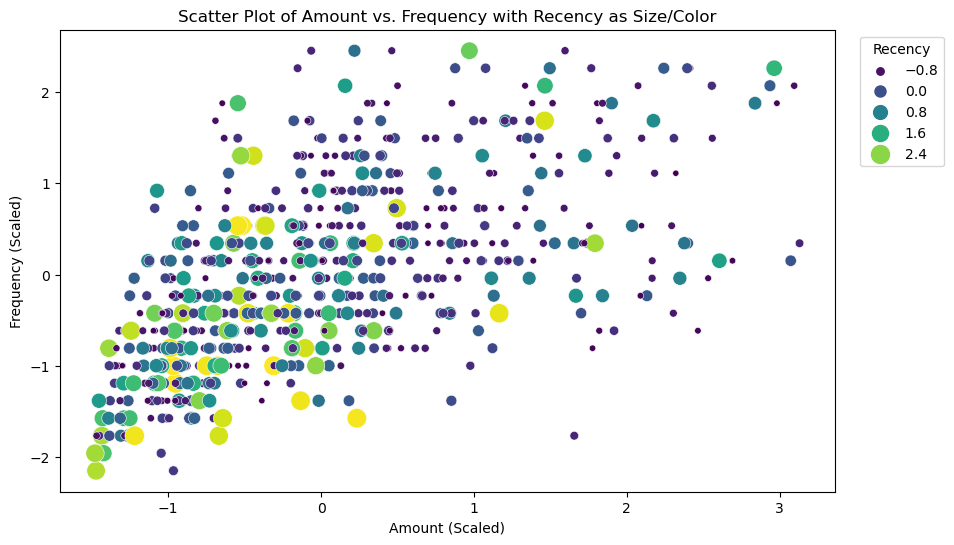

In [21]:

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Use seaborn scatter plot to include Recency as the color
scatter = sns.scatterplot(
    data=parameters_scaled, 
    x='Amount', 
    y='Frequency', 
    size='Recency', 
    hue='Recency',
    palette='viridis', 
    sizes=(20, 200), 
    legend='brief'
)

# Add labels and title
plt.xlabel('Amount (Scaled)')
plt.ylabel('Frequency (Scaled)')
plt.title('Scatter Plot of Amount vs. Frequency with Recency as Size/Color')
plt.legend(title='Recency', loc='upper right', bbox_to_anchor=(1.15, 1))

# Show the plot
plt.show()


## Building the Model

In [22]:
"""Here 4 is randomly selected as number of clusters"""

'Here 4 is randomly selected as number of clusters'

In [23]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
# Fit K-Means clustering
kmeans.fit(parameters_scaled)


c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


KMeans(max_iter=50, n_clusters=4)

In [24]:
# Assign cluster labels to each data point
kmeans.labels_
label_list=kmeans.labels_
sorted(Counter(label_list).items())

[(0, 203), (1, 247), (2, 107), (3, 106)]

In [25]:
kmeans.cluster_centers_

array([[ 0.19023154,  0.66646278, -0.43990246],
       [-0.68435526, -0.75858412, -0.3456293 ],
       [-0.51153368, -0.48063333,  1.88308234],
       [ 1.74672501,  0.97647265, -0.25301107]])

In [26]:
"""Visualizing the cnetroids"""

'Visualizing the cnetroids'

C:\Users\godwi\AppData\Local\Temp\ipykernel_9652\785489307.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.scatterplot(


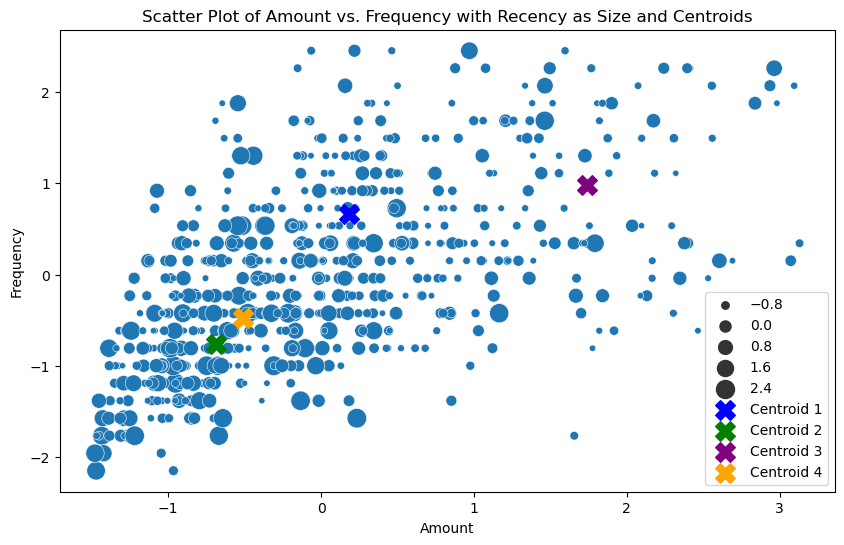

In [27]:

# Update the centroids
centroids = [[0.18357285, 0.66174109, -0.44758085],
             [-0.68467531, -0.76228487, -0.34417787],
             [1.73737329, 0.97772338, -0.24264617],
             [-0.51153368, -0.48063333, 1.88308234]]

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Use seaborn scatter plot to include Recency as the color
scatter = sns.scatterplot(
    data=parameters_scaled, 
    x='Amount', 
    y='Frequency', 
    size='Recency', 
    legend='brief',
    palette='viridis',
    sizes=(20, 200)
)

# Plot centroids with different colors
colors = ['blue', 'green', 'purple', 'orange']
for i, centroid in enumerate(centroids):
    plt.scatter(centroid[0], centroid[1], marker='X', s=200, c=colors[i], label=f'Centroid {i+1}')

# Add labels and title
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Scatter Plot of Amount vs. Frequency with Recency as Size and Centroids')

# Show legend
plt.legend()

# Show the plot
plt.show()


In [28]:
"""""Visualizing the Clusters"""

'""Visualizing the Clusters'

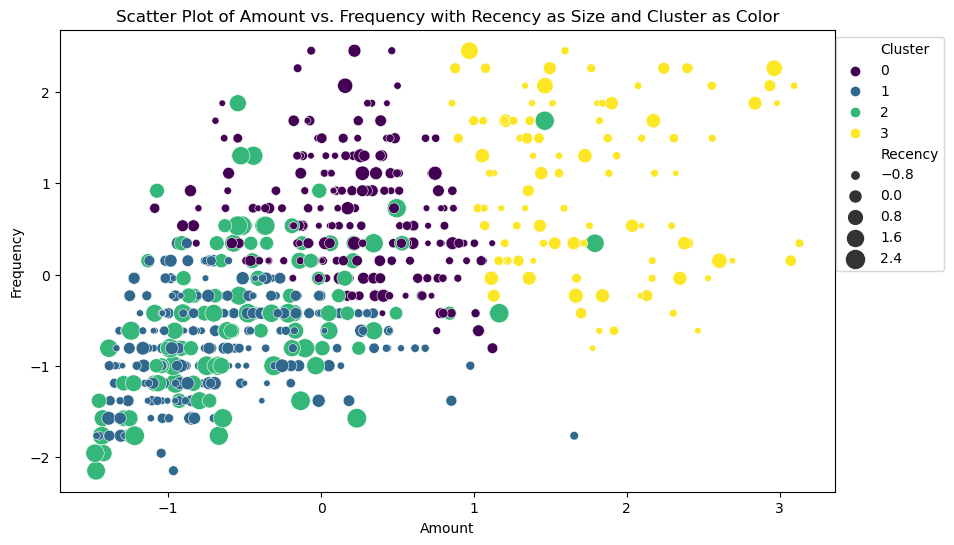

In [29]:

# Optionally, add the cluster labels to the DataFrame for further analysis
parameters_scaled['Cluster'] = label_list

# Display the DataFrame with cluster labels
#print(parameters_scaled)

# Create a scatter plot to visualize the clusters
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=parameters_scaled, 
    x='Amount', 
    y='Frequency', 
    hue='Cluster', 
    palette='viridis', 
    size='Recency', 
    sizes=(20, 200), 
    legend='brief'
)

# Add labels and title
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Scatter Plot of Amount vs. Frequency with Recency as Size and Cluster as Color')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

# Show the plot
plt.show()


In [30]:
kmeans.labels_

array([3, 0, 2, 3, 2, 1, 0, 1, 1, 2, 3, 0, 2, 3, 0, 2, 2, 1, 1, 1, 0, 0,
       1, 3, 1, 0, 0, 1, 3, 2, 1, 3, 3, 3, 1, 1, 1, 3, 0, 1, 1, 1, 3, 3,
       1, 0, 1, 0, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1, 3, 0, 3, 0, 2, 0, 1, 1,
       1, 2, 0, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 2, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 2, 2, 2, 1, 0, 2, 2, 3, 2, 0, 2, 0, 1,
       0, 1, 3, 1, 3, 0, 0, 1, 0, 0, 1, 1, 1, 2, 1, 2, 2, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 2, 3, 3, 3, 1, 1, 1, 1, 1, 0, 2, 0, 0, 1, 3, 0, 2, 0,
       1, 0, 2, 0, 2, 3, 0, 0, 3, 2, 2, 0, 1, 1, 0, 1, 1, 1, 3, 0, 1, 3,
       1, 0, 1, 3, 0, 0, 0, 0, 1, 0, 1, 3, 0, 2, 1, 1, 0, 0, 2, 3, 0, 0,
       1, 0, 1, 3, 1, 2, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 2, 2, 1,
       0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 3, 1, 2, 1, 3, 0, 0, 2, 1, 3, 2,
       3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 3, 0, 0, 1, 0,
       3, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 3, 2, 1, 1, 3, 1, 1, 3,
       2, 2, 3, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 3,

## Finding the optimal number of clusters (Evaluation Metrics)

### Elbow Method

In [31]:
from sklearn import metrics
from scipy.spatial.distance import cdist

In [32]:
"""
Build the clustering model and calculate the distortion and inertia values
"""

'\nBuild the clustering model and calculate the distortion and inertia values\n'

In [33]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
	# Building and fitting the model
	kmeanModel = KMeans(n_clusters=k).fit(parameters_scaled)
	kmeanModel.fit(parameters_scaled)

	distortions.append(sum(np.min(cdist(parameters_scaled, kmeanModel.cluster_centers_,
										'euclidean'), axis=1)) / parameters_scaled.shape[0])
	inertias.append(kmeanModel.inertia_)

	mapping1[k] = sum(np.min(cdist(parameters_scaled, kmeanModel.cluster_centers_,
								'euclidean'), axis=1)) / parameters_scaled.shape[0]
	mapping2[k] = kmeanModel.inertia_


c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4

In [34]:
"""""Tabulating and Visualizing the Results:
(a) Using the different distortion values
"""

'""Tabulating and Visualizing the Results:\n(a) Using the different distortion values\n'

In [35]:
for key, val in mapping1.items():
	print(f'{key} : {val}')


1 : 1.8626442028988195
2 : 1.4861565288572265
3 : 1.2237911361426768
4 : 0.9402634659607733
5 : 0.9014643076870257
6 : 0.8470301589771495
7 : 0.8098868168495165
8 : 0.7537039699809557
9 : 0.7318058368720574


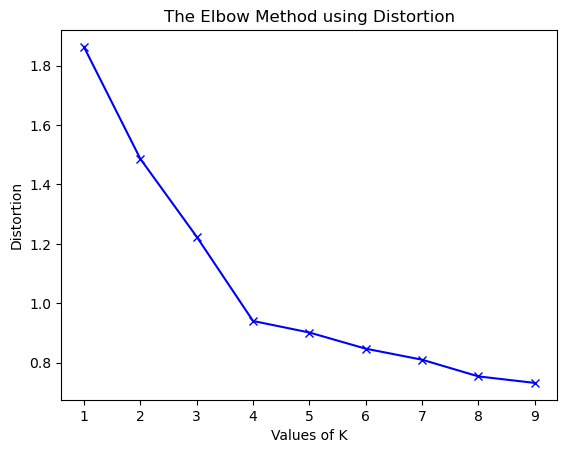

In [36]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()


In [37]:
""""
(b) Using the different inertia values
"""

'"\n(b) Using the different inertia values\n'

In [38]:
for key, val in mapping2.items():
	print(f'{key} : {val}')


1 : 2702.704374057316
2 : 1760.7594281636198
3 : 1124.1793587767445
4 : 701.4745813864176
5 : 638.1510057910141
6 : 575.3757162445183
7 : 512.712300977021
8 : 455.87198038949913
9 : 421.3028867914299


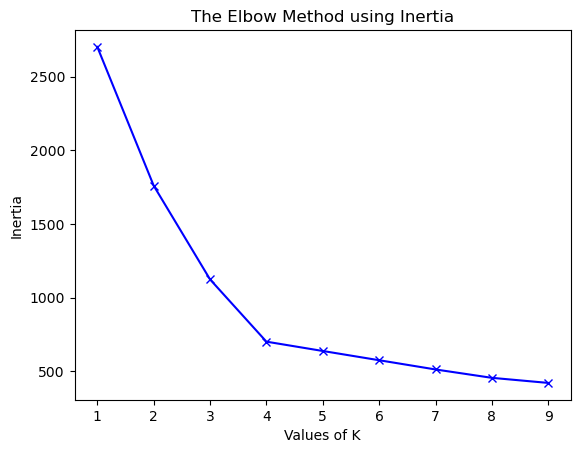

In [39]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()


In [40]:
""""
Clustering data points for different k values
"""

'"\nClustering data points for different k values\n'

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


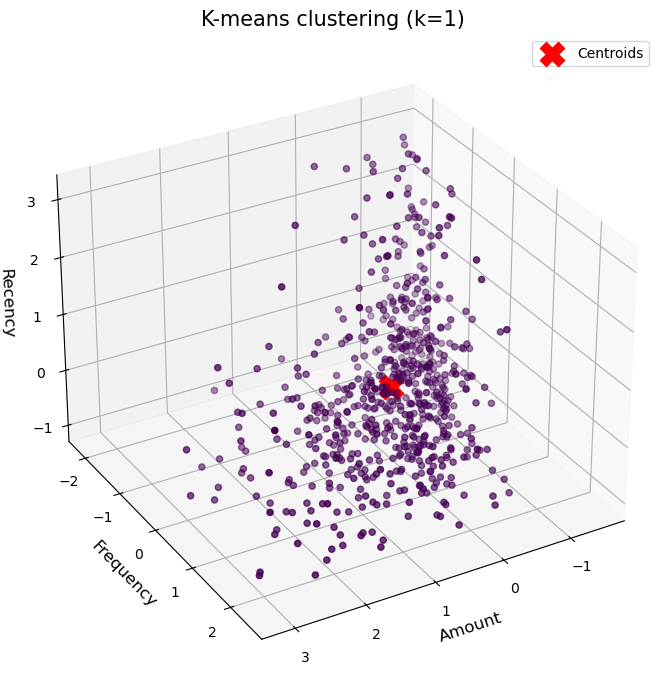

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


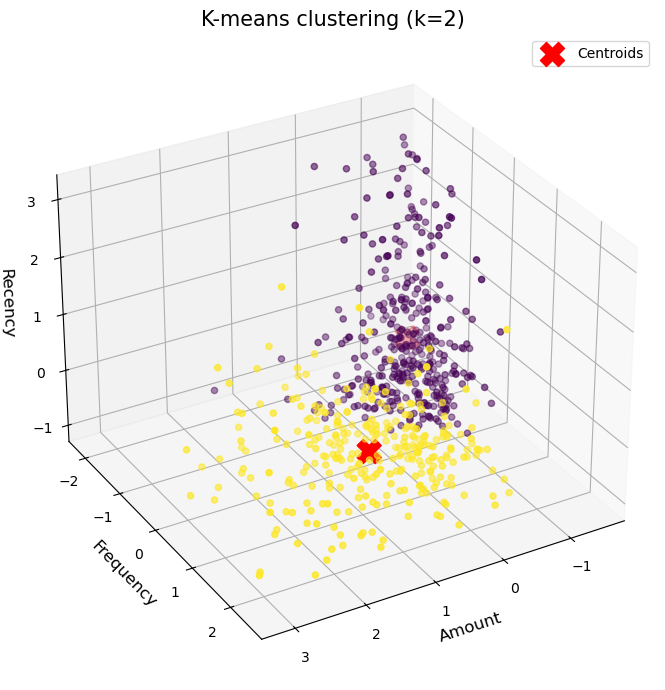

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


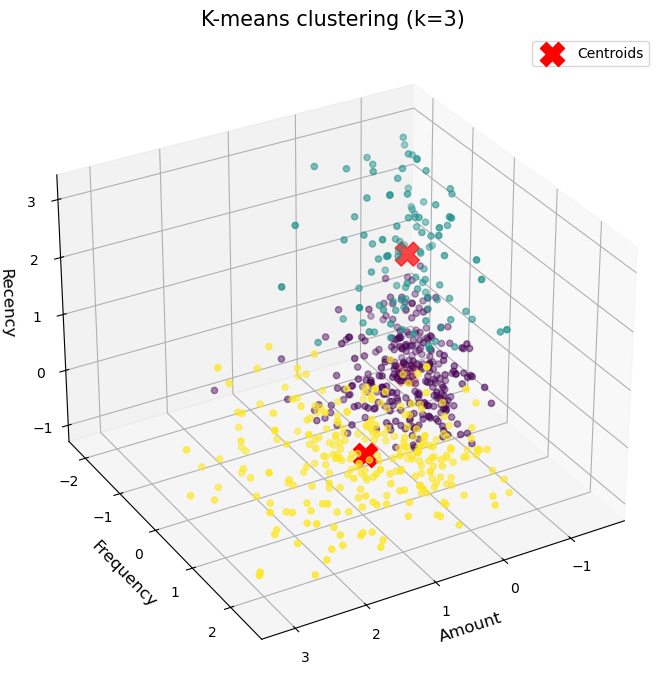

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


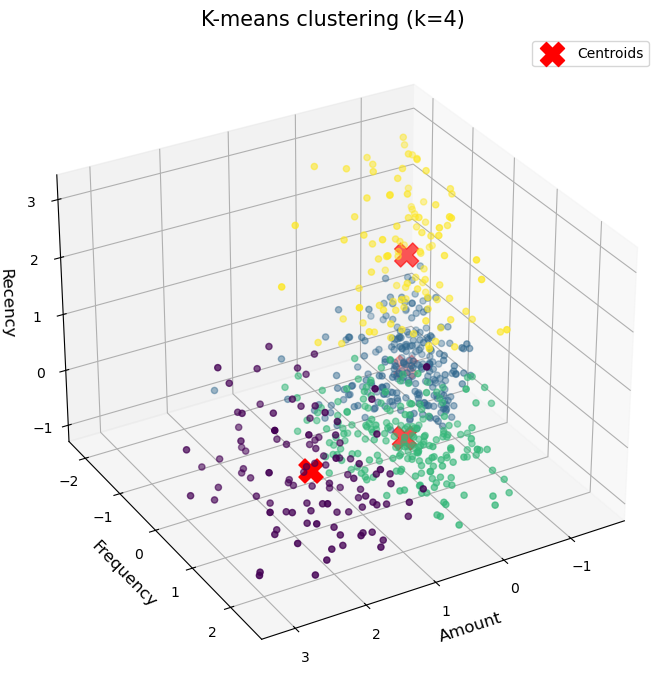

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


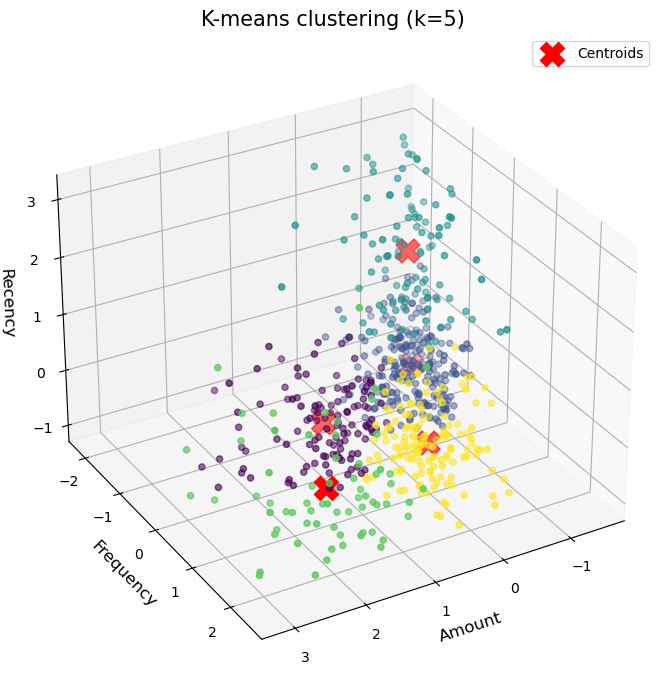

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


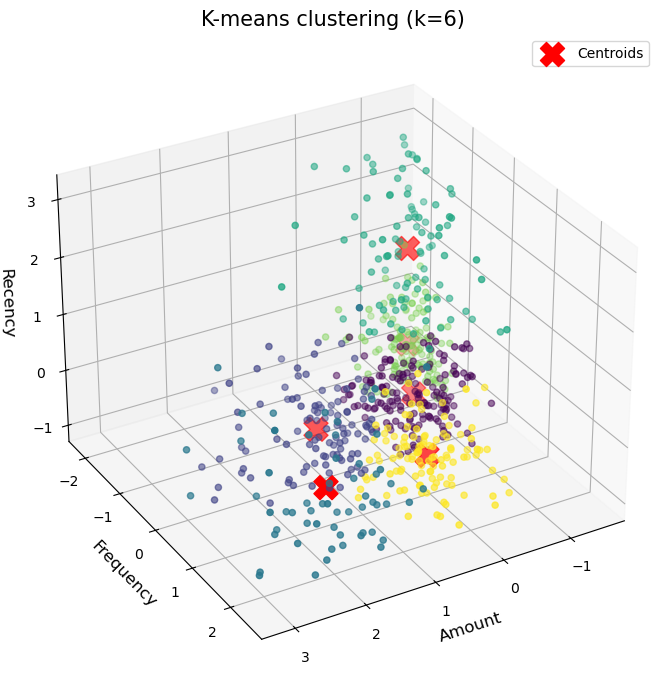

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


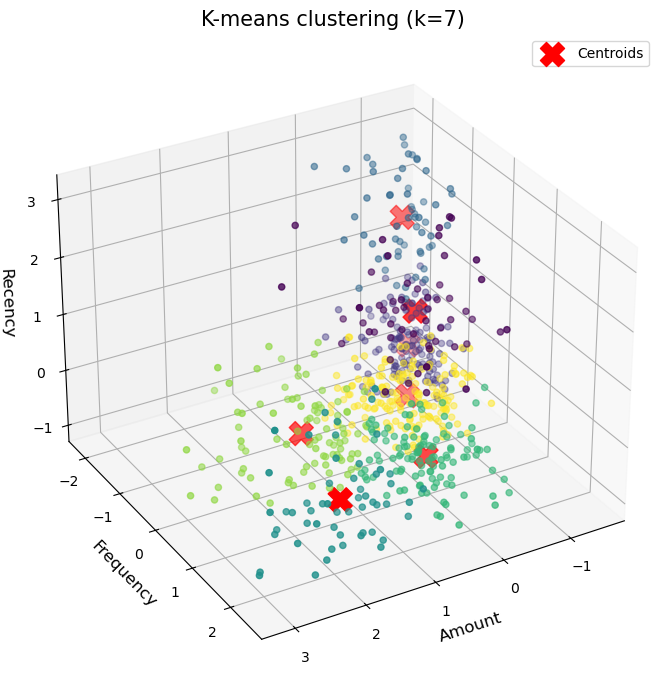

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


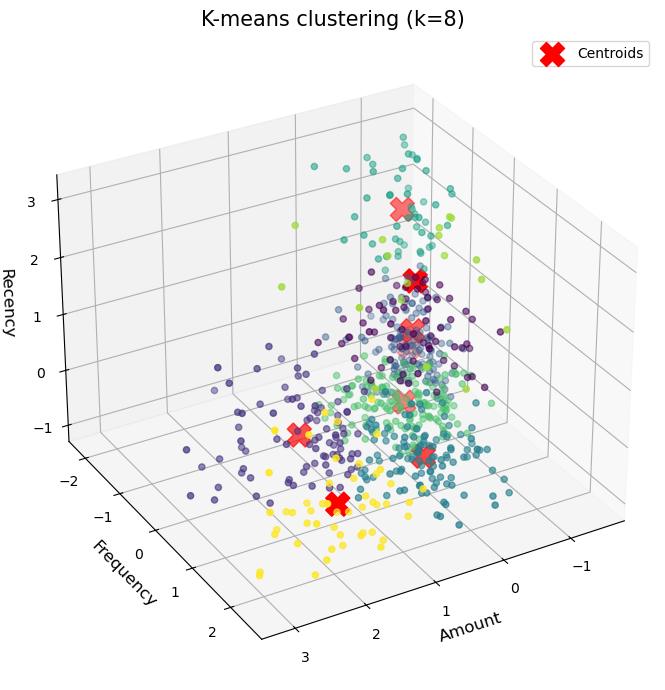

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


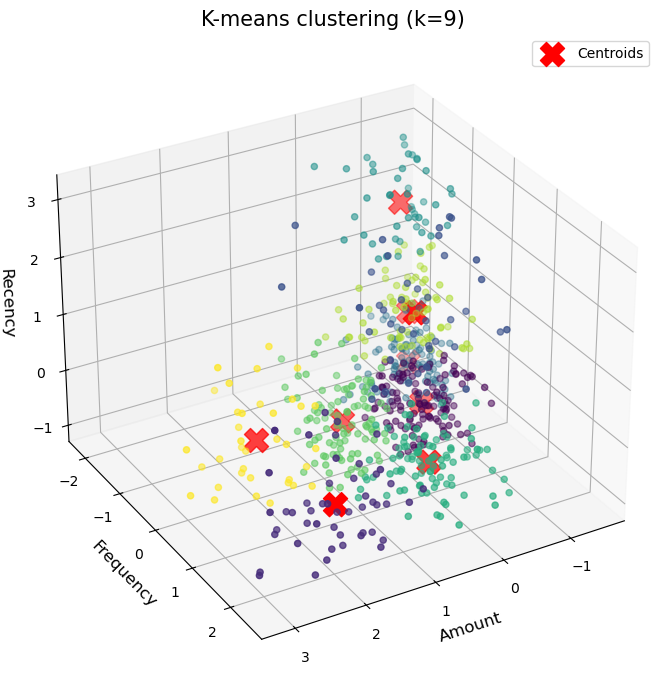

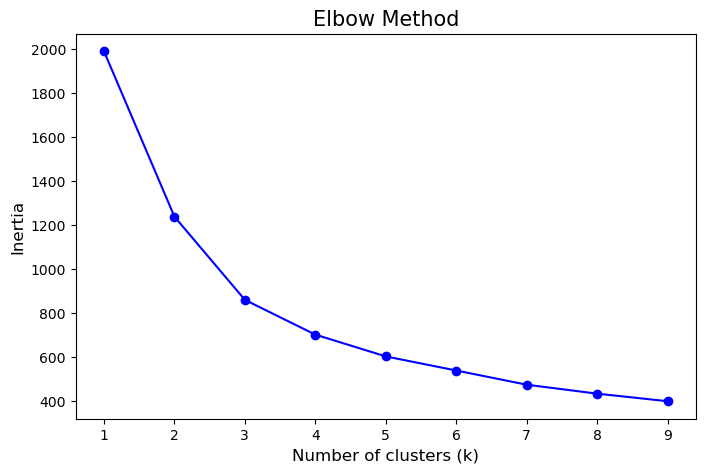

In [65]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

# Create a range of values for k
k_range = range(1, 10)

# Initialize an empty list to store the inertia values for each k
inertia_values = []

# Fit and plot the data for each k value
for k in k_range:
    kmeans = KMeans(n_clusters=k,max_iter=50, init='k-means++', random_state=42)
    y_kmeans = kmeans.fit_predict(parameters_scaled[['Amount', 'Frequency', 'Recency']])
    inertia_values.append(kmeans.inertia_)
    
    # 3D scatter plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(parameters_scaled['Amount'], parameters_scaled['Frequency'], parameters_scaled['Recency'], c=y_kmeans, cmap='viridis')
    
    # Plot centroids
    centers = kmeans.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], s=300, c='red', marker='X', label='Centroids')
    
    # Add labels and title
    ax.set_xlabel('Amount', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_zlabel('Recency', fontsize=12)
    ax.set_title('K-means clustering (k={})'.format(k), fontsize=15)
    ax.legend()
    
    # Adjust view angle
    ax.view_init(elev=30, azim=60)
    
    # Adjust layout to ensure labels are fully visible
    fig.tight_layout()
    
    plt.show()

# Plot the inertia values for each k
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia_values, 'bo-')
plt.title('Elbow Method', fontsize=15)
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.show()


### Silhoutte Analysis

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 2, the average silhouette_score is 0.34127785935046806


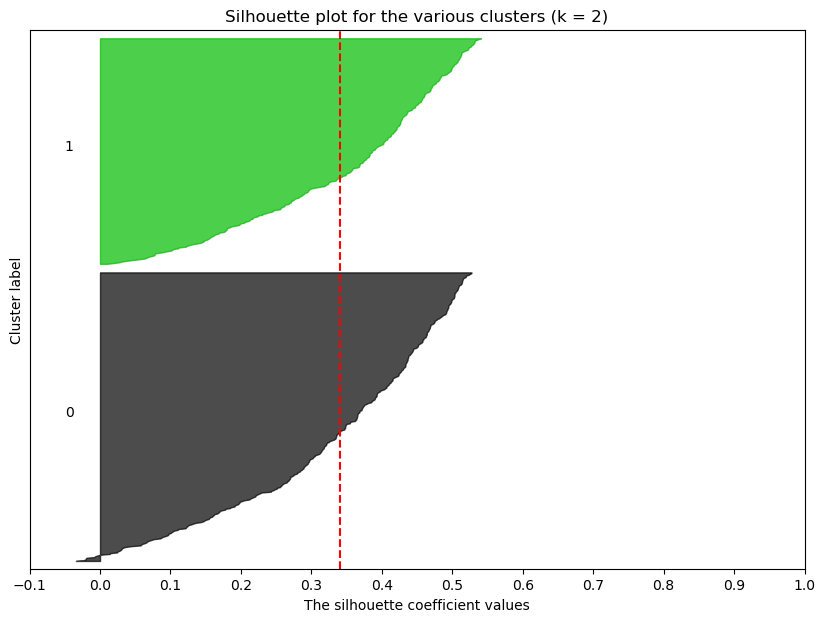

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 3, the average silhouette_score is 0.3639766085154882


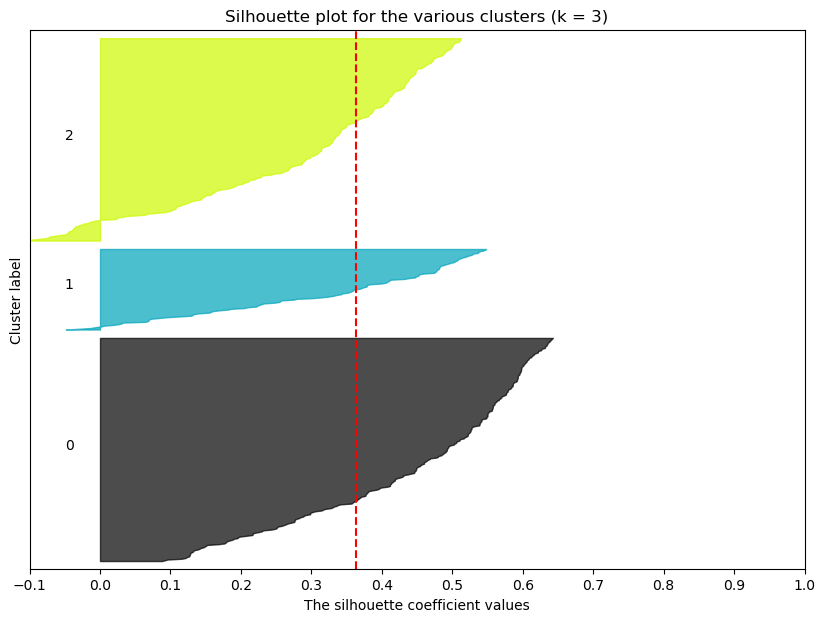

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 4, the average silhouette_score is 0.31991216682124246


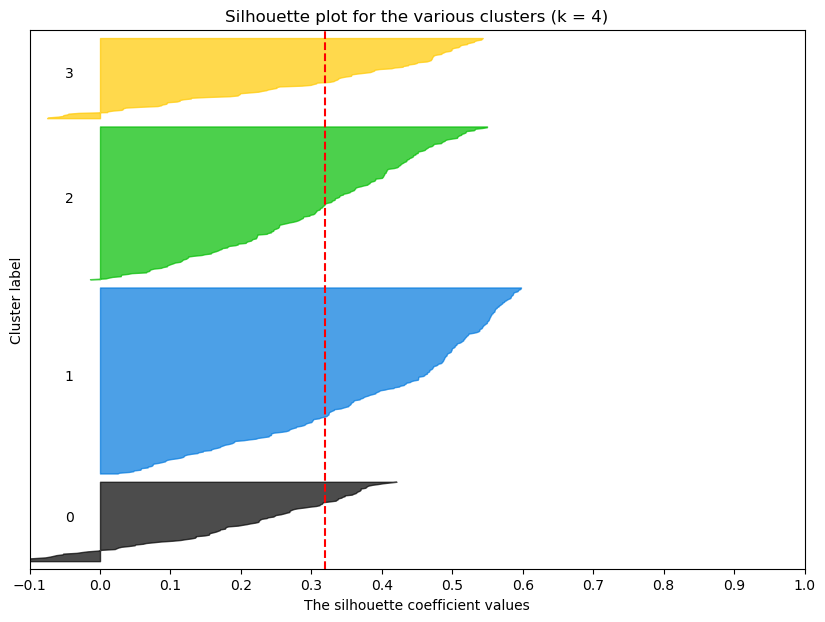

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 5, the average silhouette_score is 0.3358630532418994


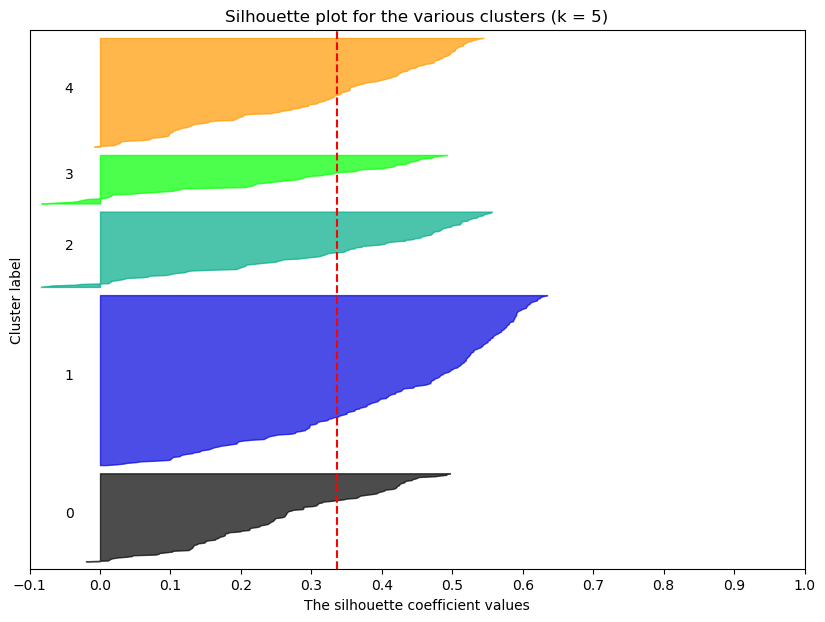

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 6, the average silhouette_score is 0.2783038524949176


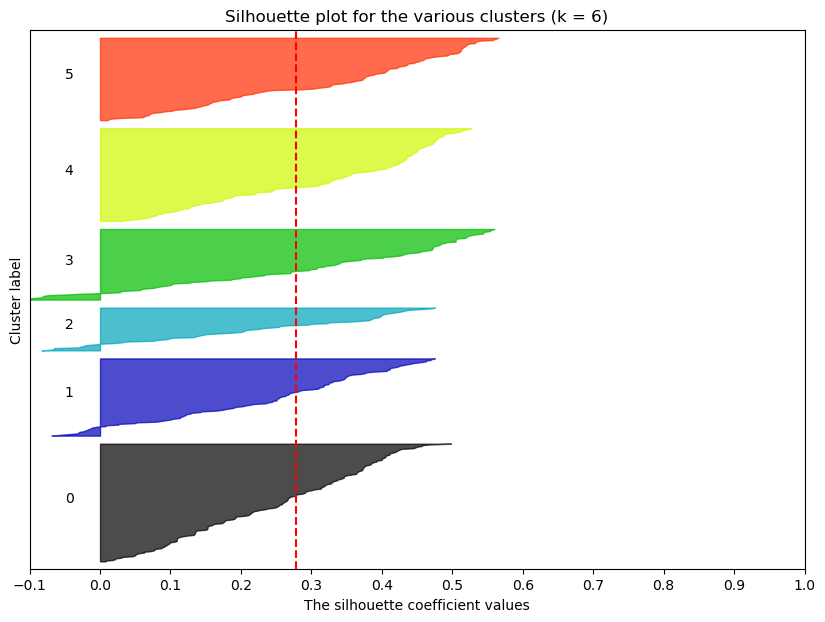

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 7, the average silhouette_score is 0.281142776787198


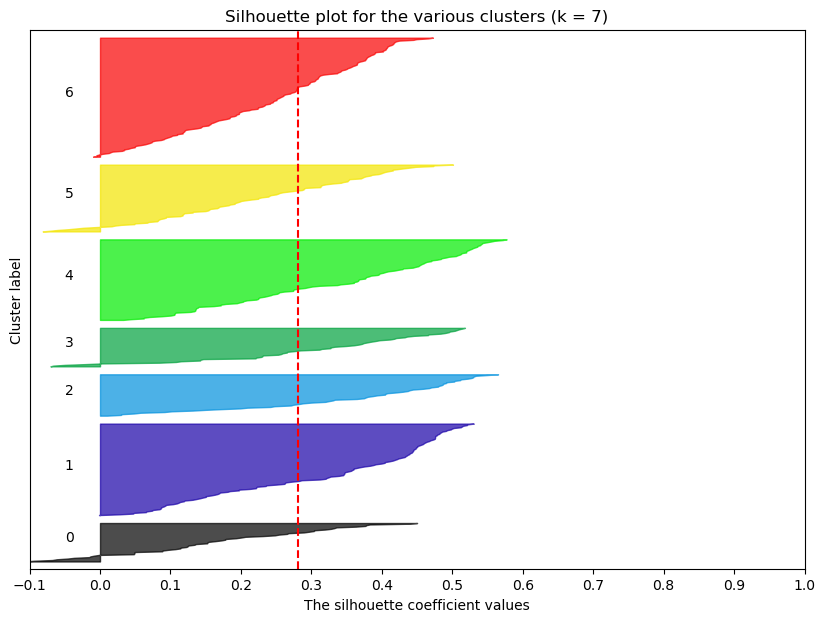

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 8, the average silhouette_score is 0.2888015690884803


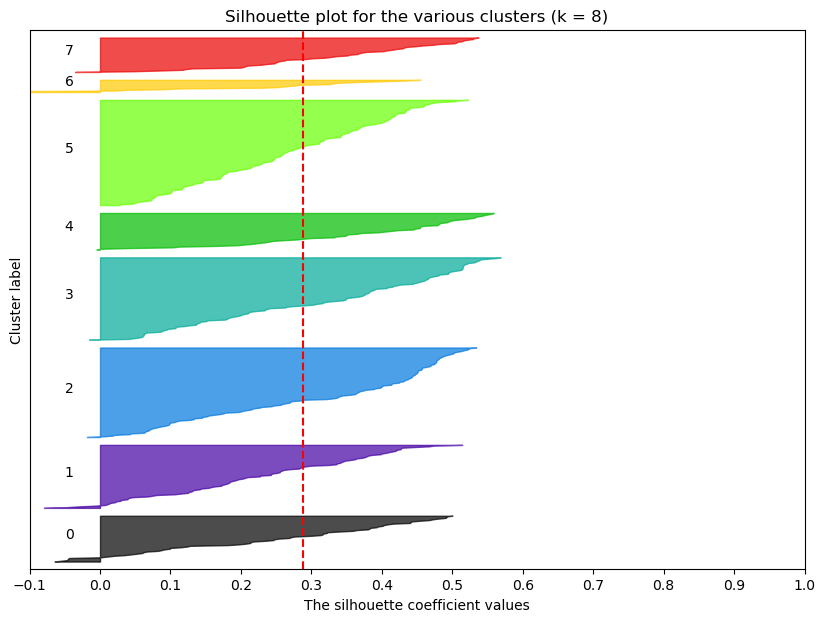

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 9, the average silhouette_score is 0.2747432730844653


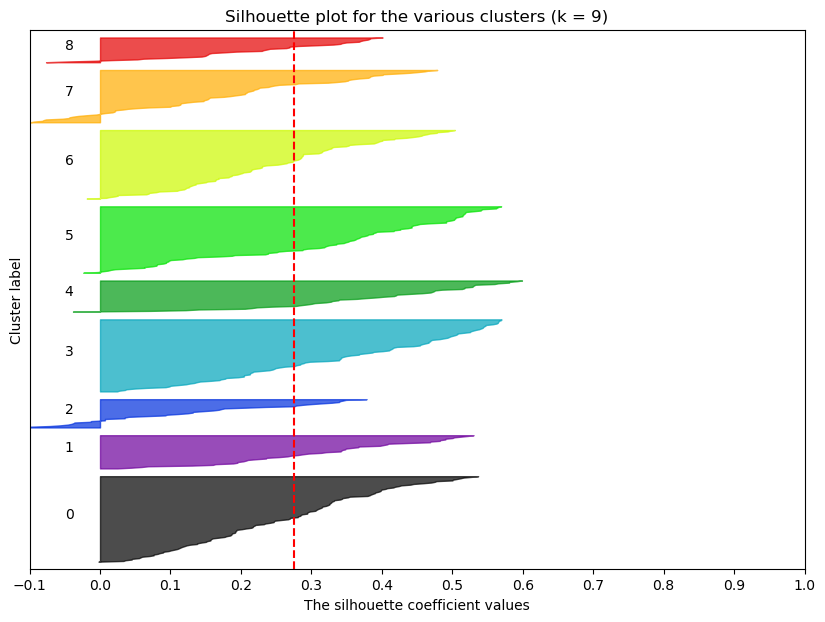

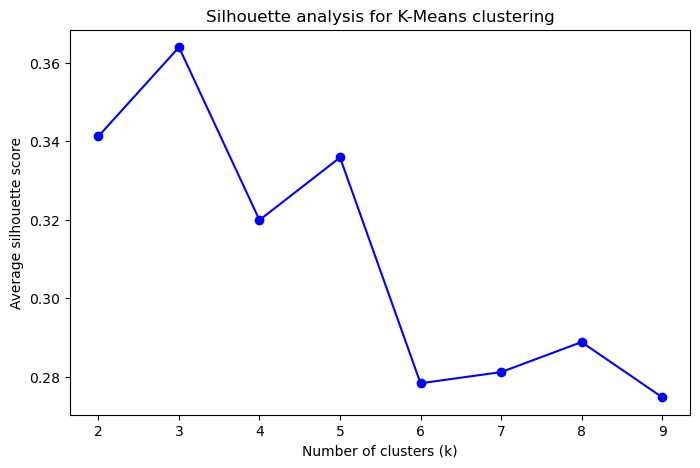

In [50]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np

# Create a range of values for k
k_range = range(2, 10)

# Initialize lists to store the average silhouette scores for each k
silhouette_avg_scores = []

# Fit the data for each k value and calculate silhouette scores
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=50, random_state=42)
    cluster_labels = kmeans.fit_predict(parameters_scaled[['Amount', 'Frequency', 'Recency']])
    
    silhouette_avg = silhouette_score(parameters_scaled[['Amount', 'Frequency', 'Recency']], cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    
    print(f"For n_clusters = {k}, the average silhouette_score is {silhouette_avg}")

    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(parameters_scaled) + (k + 1) * 10])

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(parameters_scaled[['Amount', 'Frequency', 'Recency']], cluster_labels)

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title(f"Silhouette plot for the various clusters (k = {k})")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([i / 10.0 for i in range(-1, 11)])
    plt.show()

# Plot the average silhouette scores for each k
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_avg_scores, 'bo-')
plt.title('Silhouette analysis for K-Means clustering')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average silhouette score')
plt.show()


In [43]:
# Silhouette analysis
#range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

#for num_clusters in range_n_clusters:

    # intialise kmeans
    #kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    #kmeans.fit(parameters_scaled)

    #cluster_labels = kmeans.labels_

    # silhouette score
    #silhouette_avg = silhouette_score(parameters_scaled, cluster_labels)
    #print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

## Train Model

In [58]:
"""T
raininig of the final model with the appropriate value of k.
"""

'T\nraininig of the final model with the appropriate value of k.\n'

In [62]:
# k-means with appropriate value of k
kmeans = KMeans(n_clusters=3, max_iter=50)
# Fit K-Means clustering
kmeans.fit(parameters_scaled)

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


KMeans(max_iter=50, n_clusters=3)

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



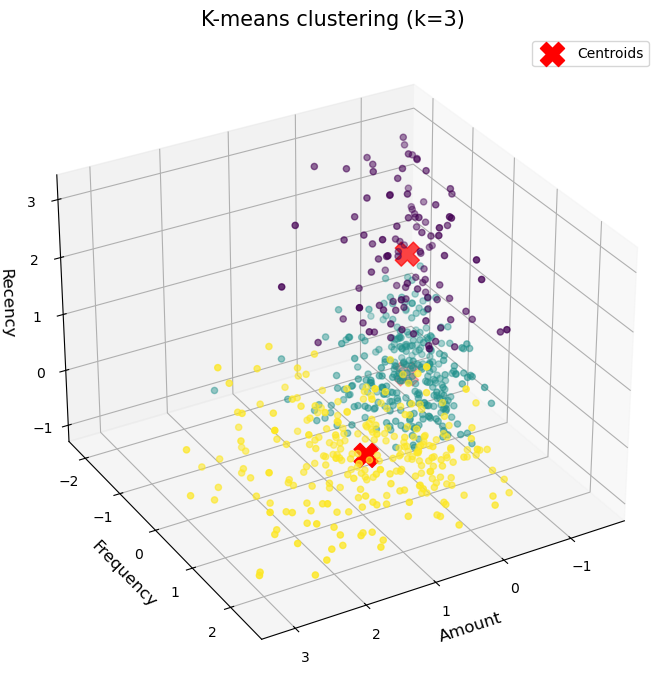

In [28]:
# Fit K-means clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
y_kmeans = kmeans.fit_predict(parameters_scaled)

# 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(parameters_scaled['Amount'], 
                     parameters_scaled['Frequency'], 
                     parameters_scaled['Recency'], 
                     c=y_kmeans, cmap='viridis')

# Plot centroids
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], 
           s=300, c='red', marker='X', label='Centroids')

# Add labels and title
ax.set_xlabel('Amount', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_zlabel('Recency', fontsize=12)
ax.set_title('K-means clustering (k={})'.format(k), fontsize=15)
ax.legend()

# Adjust view angle
ax.view_init(elev=30, azim=60)

# Adjust layout to ensure labels are fully visible
fig.tight_layout()

plt.show()

In [38]:
parameters_scaled.head()

,Amount,Frequency,Recency
0,1.841594,-0.231602,0.826249
1,-0.851013,0.535200,-0.811889
2,-0.412445,-0.039901,1.570857
3,1.556856,1.110301,-0.454477
4,-0.952712,-1.190104,3.119642


In [50]:



# Assign the cluster labels to parameters_scaled DataFrame
#parameters_scaled['Cluster_Id'] = y_kmeans

# Display the first few rows of parameters_scaled
#print(parameters_scaled.head())

# Create a DataFrame for centroids
centers = kmeans.cluster_centers_
centers_df = pd.DataFrame(centers, columns=['Amount', 'Frequency', 'Recency'])
centers_df['Cluster'] = ['Centroid']*len(centers_df)

# Create the 3D scatter plot
fig = px.scatter_3d(parameters_scaled, x='Amount', y='Frequency', z='Recency', 
                    color='Cluster_Id', symbol='Cluster_Id', title=f'K-means Clustering (k={k})',
                    labels={'Amount': 'Amount', 'Frequency': 'Frequency', 'Recency': 'Recency'},
                    opacity=0.7)

# Add centroids to the plot
fig.add_scatter3d(x=centers_df['Amount'], y=centers_df['Frequency'], z=centers_df['Recency'],
                  mode='markers', marker=dict(size=10, color='red', symbol='x'),
                  name='Centroids')

# Update layout to increase figure size and customize legend
fig.update_layout(
    scene=dict(
        xaxis_title='Amount',
        yaxis_title='Frequency',
        zaxis_title='Recency'
    ),
    width=1200,
    height=800,
    legend=dict(
        x=1.125,
        y=1,
        bgcolor='rgba(255, 255, 255, 0.5)',
        bordercolor='Black',
        borderwidth=1
    )
)

# Show the plot
fig.show()

In [53]:
cluster_labels = kmeans.labels_

In [24]:
# assign the label
parameters_cleansed['Cluster_Id'] = kmeans.labels_
parameters_cleansed.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,AA-10315,5563.560,11,184,1
1,AA-10375,1056.390,15,19,2
2,AA-10480,1790.512,12,259,0
3,AA-10645,5086.935,18,55,1
4,AB-10015,886.156,6,415,0


<Axes: xlabel='Cluster_Id', ylabel='Amount'>

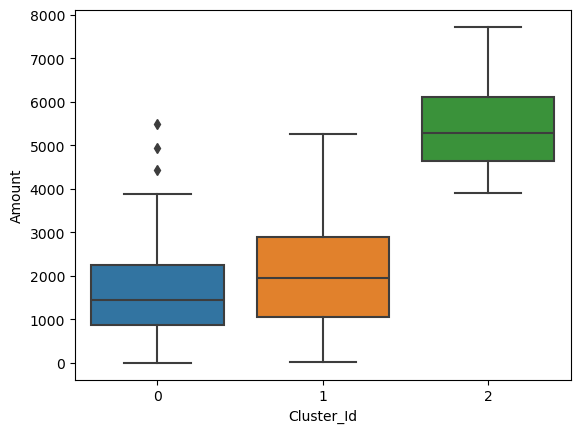

In [55]:
# Box plot to visualize Cluster Id vs Amount
sns.boxplot(x='Cluster_Id', y='Amount', data=parameters_cleansed)


<Axes: xlabel='Cluster_Id', ylabel='Frequency'>

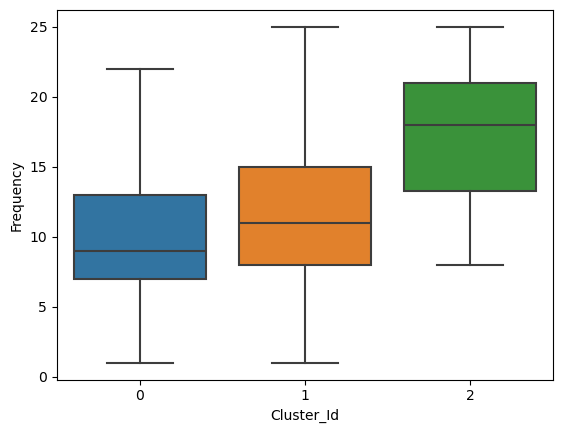

In [56]:
# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=parameters_cleansed)

<Axes: xlabel='Cluster_Id', ylabel='Recency'>

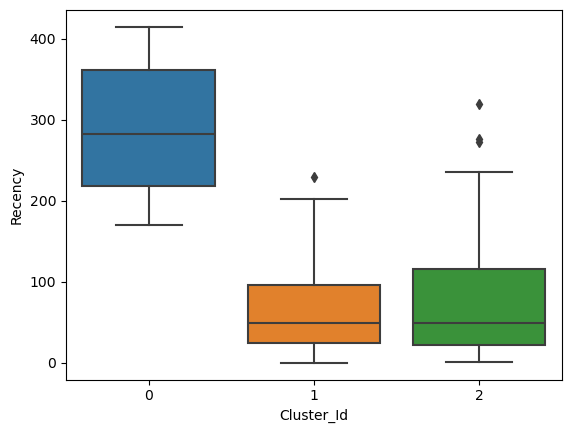

In [57]:
# Box plot to visualize Cluster Id vs Recency
sns.boxplot(x='Cluster_Id', y='Recency', data=parameters_cleansed)

In [49]:
print("Helllo World!")

Helllo World!
